In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import json
from collections import Counter
import operator
import numpy as np
import sys
import random
sys.path.append('..')
from helpers.funcs import *

In [2]:
config = json.load(open('../config.json', 'r'))
INPUT_DIR = config['INPUT_DIR']
OUTPUT_DIR = config['OUTPUT_DIR']
TWEET_DIR = config['TWEET_DIR']
RNG = random.Random()
RNG.seed(config['SEED'])
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()

## Identify retweets and tweets to be removed

Note: 
- we remove tweets with no user ids and tweets that were posted before the events
- the reason why the percentage of removed tweets varies is because some event files don't have many retweets (this is the result of the firehose storing mostly original tweets)

In [5]:
event_times = json.load(open(INPUT_DIR + "event_times.json","r"))

In [4]:
for e in events:
    data = pd.read_csv(TWEET_DIR + e + '/' + e + '.csv', sep='\t', encoding='utf-8', lineterminator='\n')
    data['remove'] = ((data['timestamp'].astype(int) < event_times[e]) | data['user_id'].isnull())
    
    # we also remove duplicate tweets because oftentimes people / institutions tweet the same using multiple accounts
    if 'is_retweet' not in data.columns:
        data['isRT'] = (data['text'].duplicated() | data['text'].str.startswith('RT'))
    else:
        data['isRT'] = (data['text'].duplicated() | (data['is_retweet'] == True))
    print(e + ':', '%.2f%% removed' % ((data['remove'] | data['isRT']).sum() * 100 / len(data)))
    data.to_csv(TWEET_DIR +e+'/'+e+'.csv', sep='\t', encoding='utf-8', index=False, line_terminator='\n')

chattanooga: 30.36% removed
roseburg: 6.64% removed
colorado_springs: 3.67% removed
san_bernardino: 28.92% removed
kalamazoo: 5.46% removed


/anaconda2/envs/nlu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


orlando: 26.10% removed


/anaconda2/envs/nlu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (12,13,14,15,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


dallas: 2.88% removed
baton_rouge: 4.84% removed
burlington: 46.65% removed
fort_lauderdale: 86.47% removed
fresno: 55.72% removed
san_francisco: 41.59% removed
vegas: 40.61% removed
thornton: 40.17% removed
sutherland_springs: 47.97% removed


/anaconda2/envs/nlu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


parkland: 49.53% removed
nashville: 55.37% removed
santa_fe: 48.19% removed
annapolis: 59.86% removed
pittsburgh: 14.91% removed
thousand_oaks: 6.70% removed


## event stats

In [5]:
for e in events:
    data = pd.read_csv(TWEET_DIR + e + '/' + e + '.csv', sep='\t', encoding='utf-8', lineterminator='\n',
                      usecols=['remove', 'isRT', 'dem_follows', 'rep_follows'])
    data = filter_retweets(data)
    print(e)
    d, r = split_party(data)
    print(str(len(data)) + ',' + str(len(d) + len(r)) + ',' + str(len(d)) + ',' + str(len(r)))

chattanooga
29573,20709,5925,14784
roseburg
18076,11505,6419,5086
colorado_springs
55843,39719,26614,13105
san_bernardino
70491,45819,20798,25021
kalamazoo
10986,6807,4350,2457
orlando
1831082,872022,450784,421238
dallas
260377,144205,64628,79577
baton_rouge
46126,29015,12019,16996
burlington
8171,4993,1838,3155
fort_lauderdale
12525,7194,3073,4121
fresno
8868,6128,1377,4751
san_francisco
10487,6627,4346,2281
vegas
1286399,726739,315343,411396
thornton
14341,9170,5527,3643
sutherland_springs
154076,106220,52513,53707
parkland
272499,186570,113856,72714
nashville
38680,24326,14606,9720
santa_fe
73621,42968,26784,16184
annapolis
27715,18468,11863,6605
pittsburgh
59925,36920,22735,14185
thousand_oaks
117815,62812,40328,22484


### look at timestamp distributions

In [11]:
hour = 60 * 60
day = 24 * hour

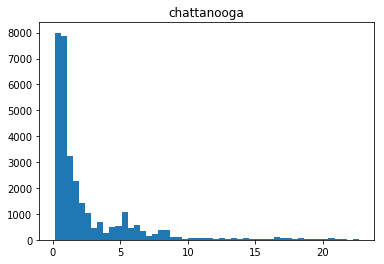

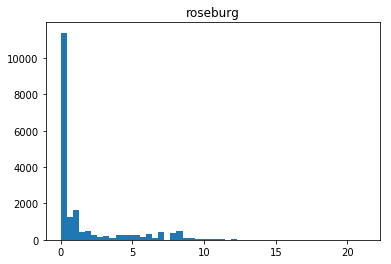

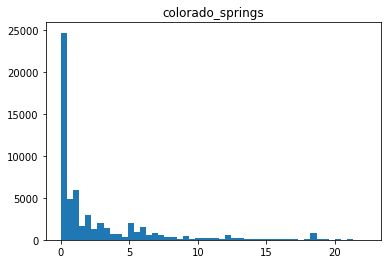

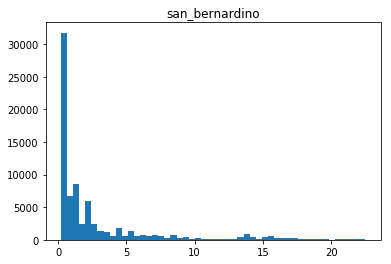

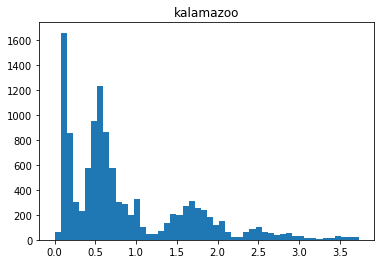

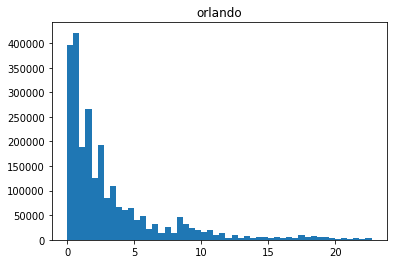

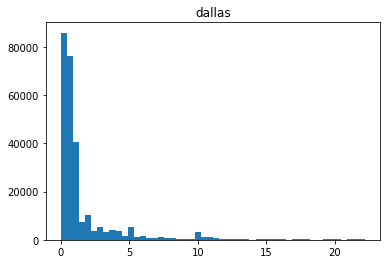

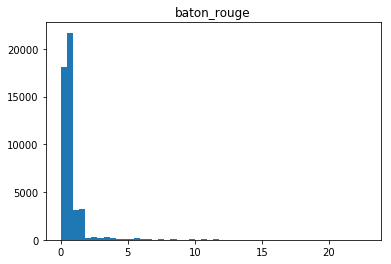

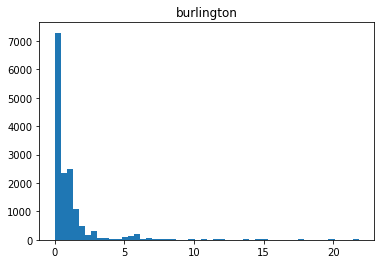

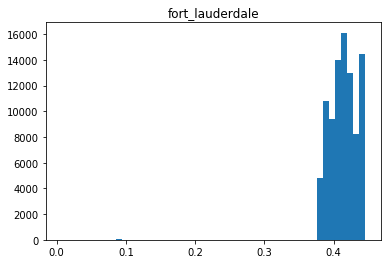

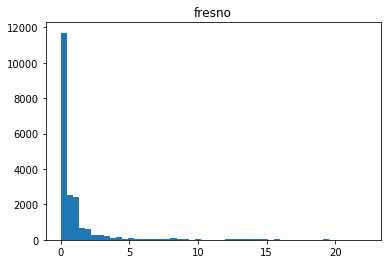

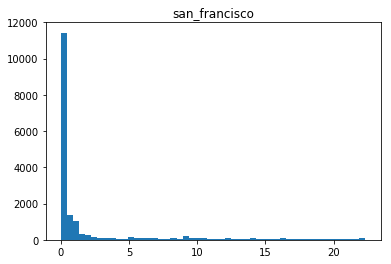

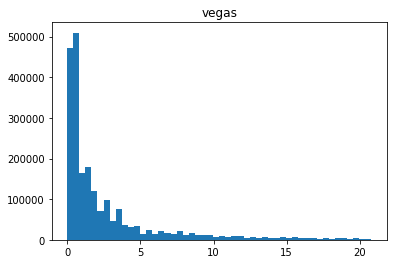

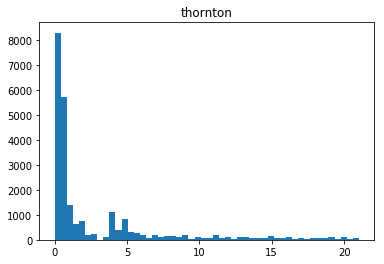

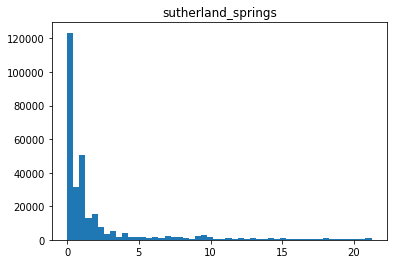

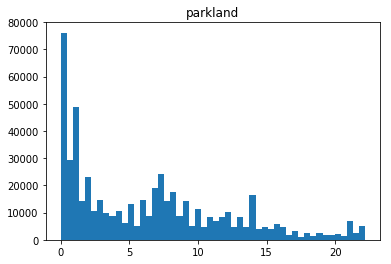

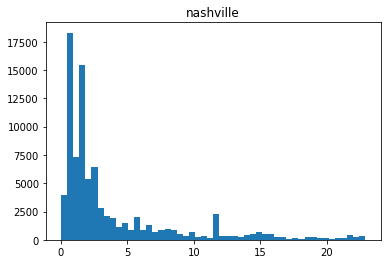

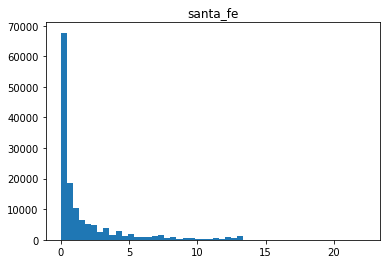

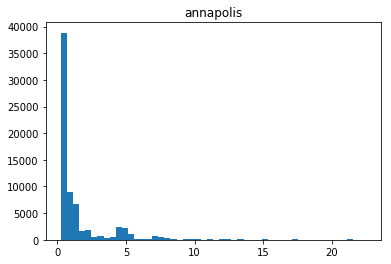

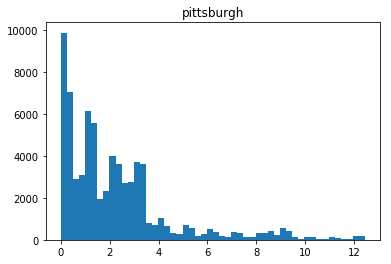

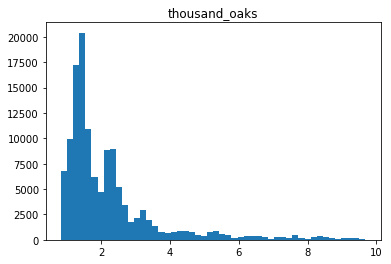

In [15]:
for e in events:
    data = pd.read_csv(TWEET_DIR + e + '/' + e + '.csv', sep='\t', encoding='utf-8', lineterminator='\n',
                      usecols=['timestamp', 'remove'])
    data = data[~data['remove']]
    plt.hist((data['timestamp']-event_times[e]) / day, bins=50)
    plt.title(e)
    plt.show()

## Build joint vocabulary

In [3]:
def get_all_vocabs(seed_val):
    vocabs = []
    for e in events:
        data = pd.read_csv(TWEET_DIR +e+'/'+e+'.csv', sep='\t', encoding='utf-8', lineterminator='\n', usecols=['text', 'remove', 'isRT'])
        data = filter_retweets(data) # ignore retweets
        #print(e, len(data))
        # sample a (quasi-)equal number of tweets from each event 
        # this has to be done to eliminate words that are too specific to a particular event
        data = data.sample(min(len(data), 10000), random_state=seed_val)
        word_counts = Counter(clean_text(' '.join(data['text']), keep_stopwords=True))
        vocab = []
        for k, v in word_counts.items():
            if v >= 10:  # keep words that occur at least 10 times
                vocab.append(k)
        vocabs.append(set(vocab))
    return vocabs

def word_event_count(vocabs):
    word_event_count = {}
    for vocab in vocabs:
        for w in vocab:
            if w in word_event_count:
                word_event_count[w] += 1
            else:
                word_event_count[w] = 1
    # Keep all words that occur in at least three events' tweets. Note that we keep stopwords.
    keep = [k for k, v in sorted(word_event_count.items(), key=operator.itemgetter(1), reverse=True) if (v > 2 and not k.isdigit())]
    print(len(keep))
    return set(keep)

In [4]:
# perform sampling 2 times and keep vocabulary that's at the intersection of both samples
num_repeats = 2
seeds = RNG.sample(range(1, 100), num_repeats)
joint_keep = None
for i in range(num_repeats):
    print(i)
    vocabs = get_all_vocabs(seeds[i])
    keep = word_event_count(vocabs)
    if not joint_keep:
        joint_keep = keep
    else:
        joint_keep = joint_keep & keep

0
2150
1
2172


In [5]:
len(joint_keep)

2041

In [6]:
with open(OUTPUT_DIR + 'joint_vocab.txt', 'w') as f:
    f.write('\n'.join(joint_keep))

## Clean up tweets

In [7]:
vocab = open(OUTPUT_DIR + 'joint_vocab.txt', 'r').read().splitlines()
vocab_set = set(vocab)

In [8]:
def clean_tweet(text):
    cleaned = clean_text(text)
    return ' '.join([w for w in cleaned if w in vocab_set])

In [9]:
for e in events:
    print(e)
    data = pd.read_csv(TWEET_DIR + e + '/' + e + '.csv', sep='\t', lineterminator='\n', usecols=['text', 'remove', 'isRT', 'dem_follows', 'rep_follows'])
    data = filter_retweets(data)  # ignore retweets, important that this doesn't reset the index
    with open(TWEET_DIR + e + '/' + e + '_cleaned_text.txt', 'w') as f:
        # clean tweets
        data['text'] = data['text'].astype(str).apply(clean_tweet)
        data = data[data['text'].str.contains(' ')]
        f.write('\n'.join(data['text']))
        
        # store the indices of cleaned tweets
        np.save(TWEET_DIR + e + '/' + e + '_cleaned_indices.npy', np.array(data.index))
        
        # store indices of cleaned AND partisan tweets
        partisan = data[~data['dem_follows'].isnull() & ~data['rep_follows'].isnull() & (data['dem_follows'] != data['rep_follows'])]
        np.save(TWEET_DIR + e + '/' + e + '_cleaned_and_partisan_indices.npy', np.array(partisan.index))
        
        # store indices of partisan tweets AMONG cleaned tweets
        data.reset_index(drop=True, inplace=True)
        data = data[~data['dem_follows'].isnull() & ~data['rep_follows'].isnull() & (data['dem_follows'] != data['rep_follows'])]
        np.save(TWEET_DIR + e + '/' + e + '_partisan_indices_among_cleaned_indices.npy', np.array(data.index))
        assert(len(partisan.index) == len(data.index))

chattanooga
roseburg
colorado_springs
san_bernardino
kalamazoo
orlando
dallas
baton_rouge
burlington
fort_lauderdale
fresno
san_francisco
vegas
thornton
sutherland_springs
parkland
nashville
santa_fe
annapolis
pittsburgh
thousand_oaks


# Build separate vocabulary

In [35]:
def build_vocab(corpus):
    freq = {}
    for words in corpus:
        prev = ''
        count = 0
        for i, w in enumerate(words):
            if w in freq:
                freq[w] += 1
            else:
                freq[w] = 1
            if count > 0:
                bigram = prev + ' ' + w
                if bigram in freq:
                    freq[bigram] += 1
                else:
                    freq[bigram] = 1
            count += 1
            prev = w
    cutoff = 50  # keep unigrams / bigrams that occur at least a 50 times
    vocab = [k for k,v in sorted(freq.items(), key=operator.itemgetter(1), reverse=True) if v > cutoff]
    return vocab

In [36]:
for i, e in enumerate(events):
    print(e)
    data = pd.read_csv(TWEET_DIR +e+'/'+e+'.csv', sep='\t', encoding='utf-8', lineterminator='\n', usecols=['text', 'remove', 'isRT'])
    data = filter_retweets(data)
    cleaned = data['text'].apply(clean_text, args=(False, e))  # don't keep stopwords
    vocab = build_vocab(cleaned)
    print(len(vocab))
    with open(TWEET_DIR +e+'/' + e+'_vocab.txt', 'w') as f:
        f.write('\n'.join(vocab))

chattanooga
1021
roseburg
592
colorado_springs
1620
san_bernardino
2010
kalamazoo
350
orlando
36966
dallas
5872
baton_rouge
1333
burlington
253
fort_lauderdale
367
fresno
297
san_francisco
315
vegas
26604
thornton
430
sutherland_springs
4531
parkland
9893
nashville
1733
santa_fe
3016
annapolis
1248
pittsburgh
2023
thousand_oaks
3120
